# Build a Meta Dataset from Multiple Datasets

We demonstrate how to concatenate multiple `dpmhm` datasets to build a new one. This is useful in particular for the Transfer Learning scenario.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

# from IPython.display import Audio

import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database
import dpmhm

from dpmhm.datasets import transformer, preprocessing, feature, utils, query_parameters

2024-06-14 10:51:46.703114: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 10:51:46.706145: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 10:51:46.750160: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 10:51:47.744986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
outdir = Path('/home/han/tmp/meta_dataset')
os.makedirs(outdir, exist_ok=True)

In [2]:
def pipeline(ds_name:str, *, split:str='all', channels:list=[], keys:list=None):
    """Pipeline of preprocessing.

    Parameters
    ----------
    ds_name
        name of the dataset
    split, optional
        split to load, by default 'all'
    channels, optional
        channels to load, by default load all channels simultaneously
    keys, optional
        keys for the ramnification of labels

    """
    ds0 = tfds.load(ds_name, split=split)
    if keys is None:
        keys = query_parameters(ds_name)['keys'].keys()

    compactor = transformer.DatasetCompactor(
        ds0,
        channels=channels, # select all channels simultaneously
        keys=keys,
        # resampling_rate=12000,
        # split_channel=True,  # split multidimensional signals into 1d signals, incompatible with the pretrained VGGish model
    )

    _func = lambda x, sr: feature.spectral_features(
        x, sr, 'spectrogram',
        # n_mfcc=256,
        time_window=0.025, hop_step=0.0125,
        # n_fft=512,
        normalize=False, to_db=True)[0]

    extractor = transformer.FeatureExtractor(compactor.dataset, _func)
    window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))

    labels = list(compactor.full_label_dict.keys())  # need the whole list of labels

    return window.dataset, labels

Full list of supported datasets in `dpmhm`:

In [3]:
dpmhm.datasets.get_dataset_list()

['CWRU',
 'Dcase2020',
 'DIRG',
 'FEMTO',
 'Fraunhofer151',
 'Fraunhofer205',
 'IMS',
 'Mafaulda',
 'Ottawa',
 'Paderborn',
 'Phmap2021',
 'SEUC',
 'XJTU']

## Load datasets

We can query the main parameters of a dataset: these will be used later to define a preprocessing pipeline.

In [4]:
ds_list = ['CWRU', 'DIRG', 'Paderborn']

# for d in ds_list:
#     print(d, query_parameters(d))

In [5]:
query_parameters('CWRU')

{'signal': {'DE': 1, 'FE': 1, 'BA': 1},
 'sampling_rate': [12000, 48000],
 'keys': {'FaultLocation': {'DriveEnd', 'FanEnd', 'None'},
  'FaultComponent': {'Ball',
   'InnerRace',
   'None',
   'OuterRace12',
   'OuterRace3',
   'OuterRace6'},
  'FaultSize': {0, 0.007, 0.014, 0.021, 0.028}},
 'filters': {'LoadForce': {0, 1, 2, 3}},
 'type': 'initiated',
 'split': ['train']}

In [6]:
query_parameters('DIRG')

{'signal': {'A1': 3, 'A2': 3},
 'sampling_rate': [51200, 102400],
 'keys': {'FaultComponent': {'InnerRing', 'Roller'},
  'FaultSize': {0, 150, 250, 450}},
 'filters': {'RotatingSpeed': {100, 200, 300, 400, 500},
  'NominalLoadForce': {0, 1000, 1400, 1800}},
 'type': 'initiated+failure',
 'split': ['vibration', 'endurance']}

In [7]:
query_parameters('Paderborn')

{'signal': {'vibration': 1, 'current': 2, 'mechanic': 3, 'temperature': 1},
 'sampling_rate': None,
 'keys': {'FaultComponent': {'Inner Ring',
   'Inner Ring+Outer Ring',
   'None',
   'Outer Ring'},
  'FaultExtend': {0, 1, 2, 3},
  'DamageMethod': {'Aritificial', 'Healthy', 'Lifetime'},
  'FaultType': {'Drilling',
   'Electric Engraver',
   'Electrical Discharge Machining',
   'Fatigue: Pitting',
   'None'}},
 'filters': {},
 'type': 'initiated+failure',
 'split': ['healthy', 'artificial', 'lifetime']}

Now use the predefined method `pipeline()` to load these datasets. 

We selectively load channels so that all samples have the same first dimension. Moreover only the split of labelled data is loaded.

For demonstration purpose, we load only a small portion of the very large `Paderborn` dataset.

In [18]:
ds_all = {}

ds_all['CWRU'] = pipeline('CWRU')
ds_all['DIRG'] = pipeline('DIRG', split='variation', channels=['A1'])
ds_all['Paderborn'] = pipeline('Paderborn', split='healthy[:25%]+artificial[:25%]', channels=['vibration', 'current'])

2024-06-14 10:58:51.665883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 10:58:51.993260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 10:58:52.314217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 10:58:52.590236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 10:58:53.391997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 10:58:54.047364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 10:58:54.833373: W tensorflow/core/framework/local_rendezvous.cc:404] L

In [19]:
ds1, ds2, ds3 = ds_all['CWRU'][0], ds_all['DIRG'][0], ds_all['Paderborn'][0]
lb1, lb2, lb3 = ds_all['CWRU'][1], ds_all['DIRG'][1], ds_all['Paderborn'][1]

It's unlikely to find duplicated labels in these datasets. Let's check:


In [39]:
labels = lb1+lb2+lb3
print(len(labels))

assert len(labels) == len(lb1)+len(lb2)+len(lb3)

45


Now we concatenate them to make a meta dataset

In [21]:
ds0 = ds1.concatenate(ds2).concatenate(ds3)

ds0.element_spec

{'feature': TensorSpec(shape=(3, None, None), dtype=tf.float32, name=None),
 'label': TensorSpec(shape=(), dtype=tf.string, name=None)}

Finally apply the preprocessing step to make it ready for supervised training:

In [22]:
preproc = preprocessing.get_mapping_supervised(labels)

# with open(outdir/'labels.json', 'w') as fp:
#     json.dump(compactor.full_label_dict,fp)

ds0 = utils.restore_shape(
    ds0.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)
)

# ds0.save(str(outdir))

2024-06-14 10:59:21.645178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 10:59:31.540360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 11:00:26.745111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 11:01:22.767934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 11:01:22.775898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Built from a concatenation, the meta dataset's size should equal to the sum of that of the composing datasets. Let's check(time-consuming step!).

In [ ]:
ds_size = utils.get_dataset_size(ds0)
print(ds_size)

ds1_size = utils.get_dataset_size(ds1)
ds2_size = utils.get_dataset_size(ds2)
ds3_size = utils.get_dataset_size(ds3)

assert ds1_size+ds2_size+ds3_size == ds_size

The meta dataset is now in a channel-last format and ready to use:

2024-06-14 11:06:28.790217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


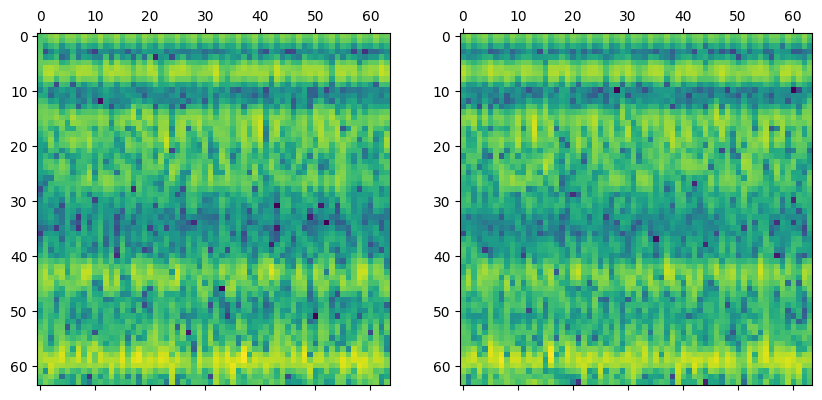

In [36]:
eles = list(ds0.take(10).as_numpy_iterator())

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].matshow(eles[0][0][:,:,0])
axes[1].matshow(eles[9][0][:,:,0])